# MNIST Loss Function Example

In [1]:
import torch
import matplotlib.pyplot as plt

import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *
#!pip install torch==1.7.0+cu110 torchvision==0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html


In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
path.ls()

(#3) [Path('/home/azhasc/.fastai/data/mnist_sample/valid'),Path('/home/azhasc/.fastai/data/mnist_sample/labels.csv'),Path('/home/azhasc/.fastai/data/mnist_sample/train')]

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [5]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [6]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

In [7]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

## Create the training set

### Concatenate to rank 2 vector

In [8]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)


### Assign labels

In [9]:
train_y = tensor([1]*len(threes) + [0]* len(sevens)).unsqueeze(1)


In [10]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

### Create the validation set

In [11]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [12]:
#Step 1

def init_params(size, std = 1.0): return (torch.randn(size)*std).requires_grad_()

In [13]:
weights = init_params((28*28,1))

In [14]:
bias = init_params(1)

## Calculate prediction for one image

In [15]:
(train_x[0]*weights.T).sum() + bias

tensor([-6.2330], grad_fn=<AddBackward0>)

In [16]:
train_x.shape

torch.Size([12396, 784])

## Prediction using matrix multiplication

In [17]:
def linear1(xb): return ((xb@weights) + bias)

preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

### Calculating accuracy

In [18]:
corrects = (preds>0.5).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [19]:
a = corrects.float().mean().item()
a

0.5355759859085083

### Change in accuracy when one of the weights is changed

In [20]:
weights[0] *= 1.001

preds = linear1(train_x)
((preds>0.5).float() == train_y).float().mean().item()

0.5355759859085083

#### As we see, accuracy does not change much, or any at all. Therefore, we need a better LOSS function. 

In [21]:
#example to show how this loss function reduces with small changes
# no zero gradient because when pred changes the loss changes cuz pred is half loss in this case


trgts = tensor([1,0,1])
prds = tensor([0.9,0.4,0.2])
prds2 = tensor([0.9,0.25,0.85])

a = torch.where(trgts == 1, 1- prds, prds)

b = torch.where(trgts == 1, 1- prds2, prds2)

print(a.float().mean().item())

print(b.float().mean().item())

print(a,b)

0.43333330750465393
0.1666666716337204
tensor([0.1000, 0.4000, 0.8000]) tensor([0.1000, 0.2500, 0.1500])


In [22]:
def mnist_loss(predictions,targets):
    return torch.where(target==1, 1-predictions,predictions)

In [23]:
#but problem is that in this case mnist loss is assumed to be always between 0 and 1. 
#So we need to make sure that happens. 
#Therefore we use the sigmoid function.

def sigmoid(x): return (1/(1+torch.exp(-x)))

/home/azhasc/anaconda3/lib/python3.8/site-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


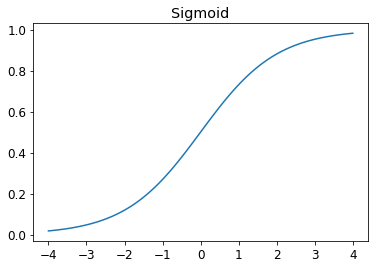

In [24]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [25]:
def mnist_sig_loss(predictions,targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1,1-predictions,predictions).mean()

In [26]:
trgts = tensor([1,0,1])
prds = tensor([0.9,0.4,0.2])
prds2 = tensor([1.9,1.25,1.85])


a = mnist_sig_loss(prds,trgts)

b = mnist_sig_loss(prds2,trgts)
print(a,b)
print(a.float().mean().item())

print(b.float().mean().item())

tensor(0.4460) tensor(0.3478)
0.44596806168556213
0.347760409116745


### Example how a DataLoader works

In [27]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

##### For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset. Here's an example of an extremely simple Dataset:

ds = L(enumerate(string.ascii_lowercase))
ds

dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

### Putting everything together

In [28]:
#initialise weights

weights = init_params((28*28,1))
bias = init_params(1)

In [29]:
#Create mini batches

dl = DataLoader(dset, batch_size = 256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [30]:
valid_dl = DataLoader(valid_dset, batch_size = 256)

In [31]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [32]:
preds = linear1(batch)
preds

tensor([[11.6180],
        [ 9.0489],
        [-2.4524],
        [-2.5197]], grad_fn=<AddBackward0>)

In [33]:
loss = mnist_sig_loss(preds,train_y[:4])
loss

tensor(0.4616, grad_fn=<MeanBackward0>)

In [34]:
loss.backward()

In [35]:
#weights and bias calculated using init_params function which uses requires_grad_
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0057), tensor([-0.0355]))

In [36]:
def cal_grad(xb,yb,model):
    preds = model(xb)
    loss = mnist_sig_loss(preds,yb)
    loss = loss.backward()
    #return weights.grad.mean(),bias.grad

In [37]:
cal_grad(batch,train_y[:4],linear1)

In [38]:
cal_grad(batch,train_y[:4],linear1)

In [39]:
## the gradients have changed for the above model, because of backprop

In [40]:
def train_epoch(model,lr,params):
    for xb,yb in dl:
        cal_grad(xb,yb,model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

In [41]:
#accuracy should be calculated too, of the validation set

(preds>0.5).float() == train_y[:4]


tensor([[ True],
        [ True],
        [False],
        [False]])

In [42]:
#definig accuracy function

def batch_accuracy(xb,yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [43]:
type(batch_accuracy(linear1(batch),train_y[:4]))

torch.Tensor

In [44]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb),yb) for xb,yb in dl]
    return round(torch.stack(accs).mean().item(),4)

In [45]:
validate_epoch(linear1)

0.557

In [46]:
lr = 1.0
params = weights,bias

train_epoch(linear1,lr,params)

In [47]:
validate_epoch(linear1)

0.6564

In [48]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.832 0.9177 0.9442 0.9553 0.9614 0.9665 0.9692 0.9712 0.9737 0.9746 0.9755 0.9762 0.9769 0.9778 0.9783 0.979 0.9794 0.9797 0.98 0.9801 

## Creating an optimizer

In [49]:
linear_model = nn.Linear(28*28,1)

w,b = linear_model.parameters() 
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [50]:
class BasicOptim:
    
    def __init__(self,params,lr): 
        self.params,self.lr = list(params), lr
        
    def step(self, *args, **kwargs): 
        for p in self.params:
            p.data -= p.grad.data * lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [51]:
opt = BasicOptim(linear_model.parameters(),lr)

In [52]:
def train_epoch(model):
    for xb,yb in dl:
        cal_grad(xb,yb,model)
        opt.step()
        opt.zero_grad()

In [53]:
validate_epoch(linear_model)

0.3811

In [54]:
def train_model(model,epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end = '')

In [55]:
train_model(linear_model,20)

0.48880.76360.85020.90590.93140.94560.95340.95910.96470.96810.97080.97270.97410.97510.97620.97690.97780.97830.97890.9798

In [56]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.48880.81070.84720.90630.93180.94590.95360.95960.96520.96850.97070.9730.97440.97510.97620.9770.97780.97840.9790.9796

In [57]:
dls = DataLoaders(dl, valid_dl)

To create a Learner without using an application (such as cnn_learner) we need to pass in all the elements that we've created in this chapter: the DataLoaders, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [60]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_sig_loss, metrics=batch_accuracy)

In [61]:
learn.fit(10, lr = lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636784,0.503385,0.495584,00:00
1,0.481311,0.204066,0.826300,00:00
2,0.178204,0.176501,0.839549,00:00
3,0.079017,0.106269,0.911187,00:00
4,0.042443,0.078025,0.932777,00:00
5,0.028133,0.062590,0.946025,00:00
6,0.022230,0.052910,0.955348,00:00
7,0.019588,0.046466,0.962709,00:00
8,0.018230,0.041952,0.965653,00:00
9,0.017402,0.038634,0.967125,00:00


## Converting to a neural network

In [68]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))   #takes the max of res and 0, converts all negative numbers to zero, 
                                           #also known as ReLu function
    res = res@w2 + b2
    return res
    

In [69]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

# w1 has 30 o/p activations, therefore, w2 must have 30 i/p, they must match

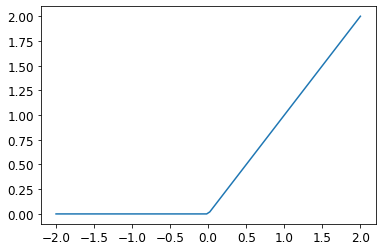

In [70]:
plot_function(F.relu)

In [71]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [74]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_sig_loss, metrics=batch_accuracy)

In [75]:
learn.fit(20, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.313382,0.416005,0.504416,00:00
1,0.145429,0.230025,0.799804,00:00
2,0.080194,0.115028,0.917076,00:00
3,0.052595,0.077700,0.940628,00:00
4,0.039840,0.060676,0.954858,00:00
5,0.033341,0.051112,0.964181,00:00
6,0.029615,0.045101,0.966143,00:00
7,0.027202,0.040997,0.967125,00:00
8,0.025469,0.038020,0.968106,00:00
9,0.024132,0.035748,0.971541,00:00


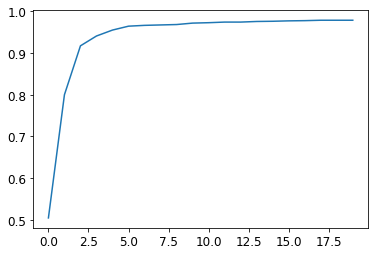

In [77]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [78]:
learn.recorder.values[-1][2]

0.9784101843833923

In [79]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.098737,0.007145,0.997056,00:13
